# 1. Introduction

A brief description of your approach to the problem and the results that you 
have obtained on the training data.

\*Insert Introduction here\*

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such 
a way that I can modify it to run on my own machine by simply changing the location 
of the training data and any additional data sources that you have used.

In [59]:
# I intend to use Data Frames to hold our data for now. When putting it in the model,
# I will probably have to change it to another format later but that is a problem for future me, not current me
# (Im joking; please dont deduct points, Mr/Ms Marker)
# Seriously though, Data Frames have very good performance and are malleable for data investigation,
# hence my decision to use them.

import pandas as pd
from pandas import DataFrame as df
import csv

def dataframe_from_diabetic_data_csv(csv_filepath):
    return pd.read_csv(csv_filepath)

TRAINING_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_training.csv"
TEST_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_test.csv"

training_data = dataframe_from_diabetic_data_csv(TRAINING_DATA_FILEPATH)
test_data = dataframe_from_diabetic_data_csv(TEST_DATA_FILEPATH)

print(training_data)



       encounter_id  patient_nbr             race  gender      age weight  \
0            149190     55629189        Caucasian  Female  [10-20)      ?   
1             64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2            500364     82442376        Caucasian    Male  [30-40)      ?   
3             16680     42519267        Caucasian    Male  [40-50)      ?   
4             35754     82637451        Caucasian    Male  [50-60)      ?   
...             ...          ...              ...     ...      ...    ...   
91584     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
91585     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
91586     443854148     41088789        Caucasian    Male  [70-80)      ?   
91587     443857166     31693671        Caucasian  Female  [80-90)      ?   
91588     443867222    175429310        Caucasian    Male  [70-80)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \


# 3. Data Transformation and Exploration
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [60]:
# I'm going to create some helper functions that might become useful in future.
# Using a few dictionaries I'll allow for mapping from discharge IDs, admission type IDs,
# and admission source IDs, to their true meaning


id_mapping_file_path = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/IDS_mapping.csv"
admission_type_ids = {}
discharge_ids = {}
admission_source_ids = {}

with open(id_mapping_file_path, newline = '') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in csvreader:
        if row[0] == 'admission_type_id':
            current_dictionary = 'AT'
        elif row[0] == 'discharge_disposition_id':
            current_dictionary = 'DD'
        elif row[0] == 'admission_source_id':
            current_dictionary = 'AS'
        elif row[0] == '':
            continue
        elif current_dictionary == 'AT':
            admission_type_ids[int(row[0])] = row[1]
        elif current_dictionary == 'DD':
            discharge_ids[int(row[0])] = row[1]
        else:
            admission_source_ids[int(row[0])] = row[1]
        
def get_admission_type(admission_type_id):
    try:
        return admission_type_ids[admission_type_id]
    except:
        return 'INVALID ADMISSION TYPE ID'

def get_discharge_type(discharge_id):
    try:
        return discharge_ids[discharge_id]
    except:
        return 'INVALID DISCHARGE ID'

def get_admission_source_ids(admission_source_id):
    try:
        return admission_source_ids[admission_source_id]
    except:
        return 'INVALID ADMISSION SOURCE ID'

#print(admission_type_ids)
#print(discharge_ids)
#print(admission_source_ids)

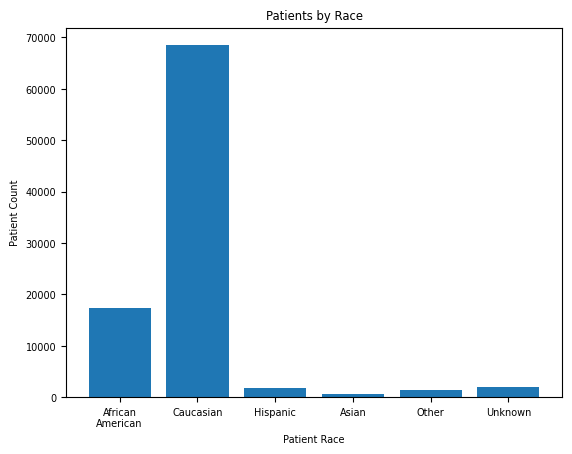

In [61]:
# I want to create some data visualisations that can provide some insights.
# I intend to use these insights to inform how I set up the model's architecture

import matplotlib
from matplotlib import pyplot as plt

# Grouping Patients by Race
african_americans = training_data[training_data['race']=='AfricanAmerican']
african_american_patients = len(african_americans)

caucasians = training_data[training_data['race'] == 'Caucasian']
caucasian_patients = len(caucasians)

hispanics = training_data[training_data['race'] == 'Hispanic']
hispanic_patients = len(hispanics)

asians = training_data[training_data['race'] == 'Asian']
asian_patients = len(asians)

others = training_data[training_data['race'] == 'Other']
other_race_patients = len(others)

unknowns = training_data[training_data['race'] == '?']
unknown_race_patients = len(unknowns)

races = ['African\nAmerican', 'Caucasian', 'Hispanic', 'Asian', 'Other', 'Unknown']
patient_counts = [african_american_patients, caucasian_patients, hispanic_patients, asian_patients, other_race_patients, unknown_race_patients]

plt.bar(races, patient_counts)
plt.title("Patients by Race")
plt.xlabel("Patient Race")
plt.ylabel("Patient Count")
plt.show()

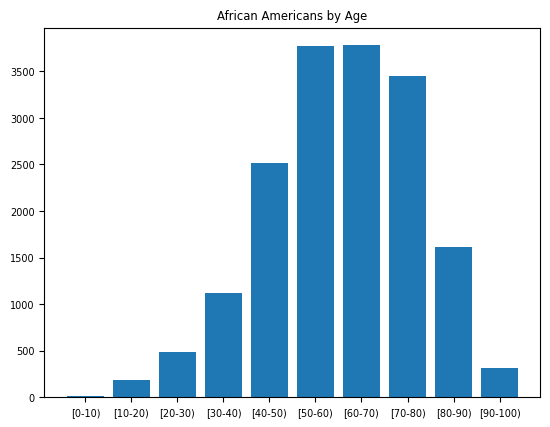

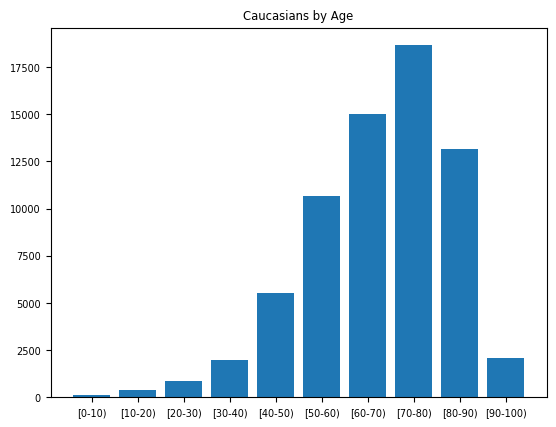

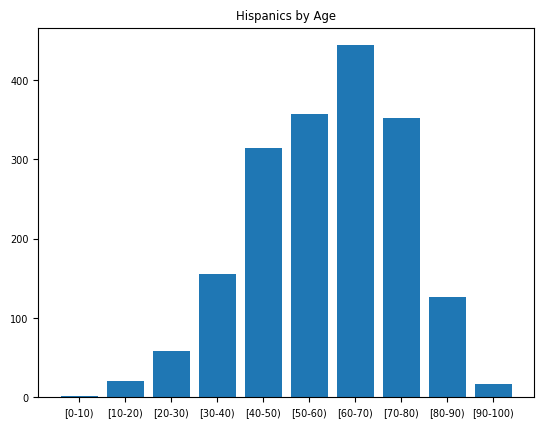

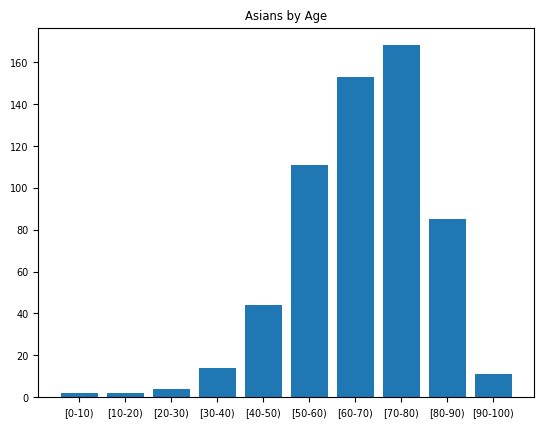

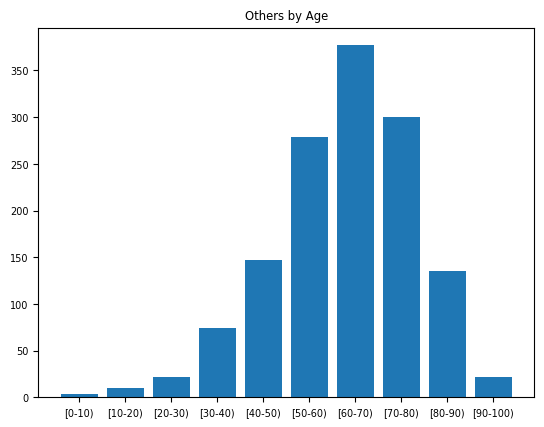

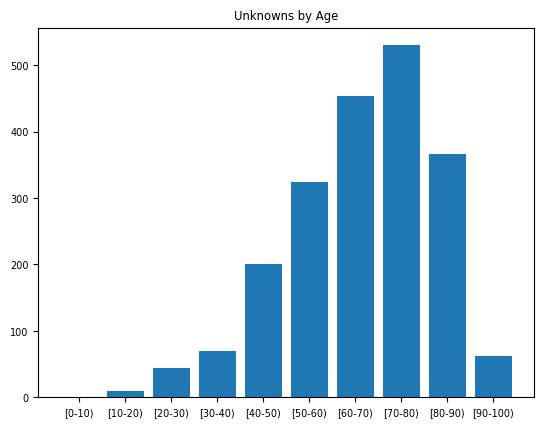

In [62]:
# Grouping patients by age within race
# '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[80-90)' '[90-100)' '[0-10)'
age_brackets = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
african_americans_by_age = [len(african_americans[african_americans['age'] == bracket]) for bracket in age_brackets]
caucasians_by_age = [len(caucasians[caucasians['age'] == bracket]) for bracket in age_brackets]
hispanics_by_age = [len(hispanics[hispanics['age'] == bracket]) for bracket in age_brackets]
asians_by_age = [len(asians[asians['age'] == bracket]) for bracket in age_brackets]
others_by_age = [len(others[others['age'] == bracket]) for bracket in age_brackets]
unknowns_by_age = [len(unknowns[unknowns['age'] == bracket]) for bracket in age_brackets]

plt.rcParams.update({'font.size': 7})

plt.bar(age_brackets, african_americans_by_age)
plt.title('African Americans by Age')
plt.show()

plt.bar(age_brackets, caucasians_by_age)
plt.title('Caucasians by Age')
plt.show()

plt.bar(age_brackets, hispanics_by_age)
plt.title('Hispanics by Age')
plt.show()

plt.bar(age_brackets, asians_by_age)
plt.title('Asians by Age')
plt.show()

plt.bar(age_brackets, others_by_age)
plt.title('Others by Age')
plt.show()

plt.bar(age_brackets, unknowns_by_age)
plt.title('Unknowns by Age')
plt.show()

plt.rcParams.clear()
# african_american_axes = plt.subplot(3, 3, 1)
# african_american_axes.bar(age_brackets, african_americans_by_age)
# african_american_axes.set_title('African Americans by Age', fontsize = 7)


# caucasian_axes = plt.subplot(3, 3, 2)
# caucasian_axes.bar(age_brackets, caucasians_by_age)
# caucasian_axes.set_title('Caucasians by Age', fontsize = 7)


# hispanic_axes = plt.subplot(3, 3, 3)
# hispanic_axes.bar(age_brackets, hispanics_by_age)
# hispanic_axes.set_title('Hispanics by Age', fontsize = 7)


# asian_axes = plt.subplot(3, 3, 4)
# asian_axes.bar(age_brackets, asians_by_age)
# asian_axes.set_title('Asians by Age', fontsize = 7)


# other_axes = plt.subplot(3, 3, 5)
# other_axes.bar(age_brackets, others_by_age)
# other_axes.set_title('Others by Age', fontsize = 7)


# unknown_axes = plt.subplot(3, 3, 6)
# unknown_axes.bar(age_brackets, unknowns_by_age)
# unknown_axes.set_title('Unknowns by Age', fontsize = 7)


# plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

# plt.show()



1:  Physician Referral
2: Clinic Referral
3: HMO Referral
4: Transfer from a hospital
5:  Transfer from a Skilled Nursing Facility (SNF)
6:  Transfer from another health care facility
7:  Emergency Room
8:  Court/Law Enforcement
9:  Not Available
10:  Transfer from critial access hospital
11: Normal Delivery
13:  Sick Baby
14:  Extramural Birth
17: NULL
20:  Not Mapped
22:  Transfer from hospital inpt/same fac reslt in a sep claim
25:  Transfer from Ambulatory Surgery Center


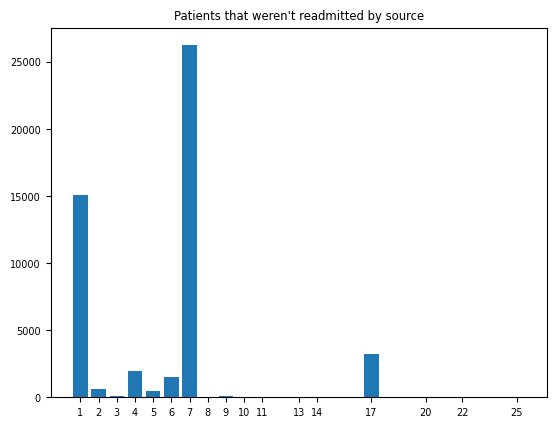

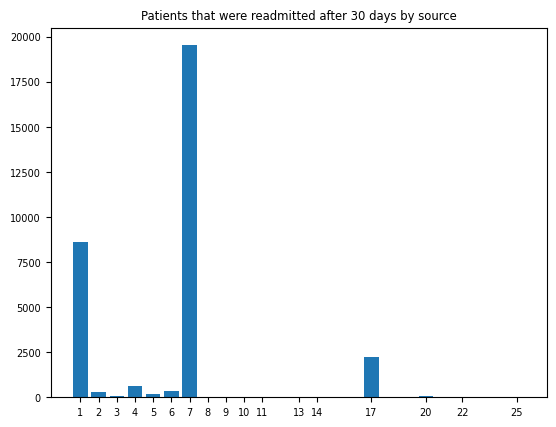

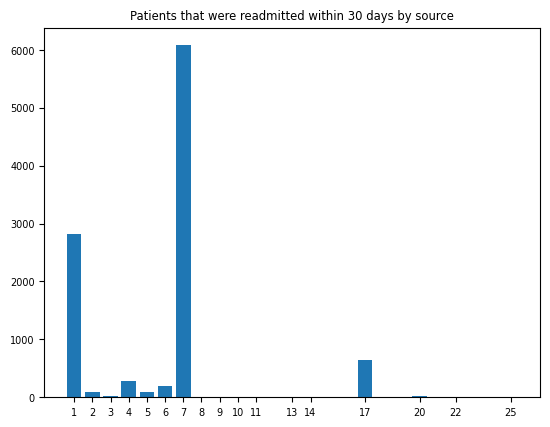

In [63]:
# Let's visualise the patient's outcome (readmittance) based on their admittance

patients_not_readmitted = training_data[training_data['readmitted'] == 'NO']
patients_readmitted_after_30_days = training_data[training_data['readmitted'] == '>30']
patients_readmitted_within_30_days = training_data[training_data['readmitted'] == '<30']

admission_sources = list(training_data['admission_source_id'].unique())
admission_sources.sort()

# Now that we have the patients separated by their outcome, lets visualise what made them go to the hospital
not_readmitted_patients_by_source = [len(patients_not_readmitted[patients_not_readmitted['admission_source_id'] == aso]) for aso in admission_sources]
readmitted_patients_after_30_days_by_source = [len(patients_readmitted_after_30_days[patients_readmitted_after_30_days['admission_source_id'] == aso]) for aso in admission_sources]
readmitted_patients_within_30_days_by_source = [len(patients_readmitted_within_30_days[patients_readmitted_within_30_days['admission_source_id'] == aso]) for aso in admission_sources]

for aso in admission_sources:
    print(f"{aso}: {get_admission_source_ids(aso)}")

plt.bar(admission_sources, not_readmitted_patients_by_source)
plt.title("Patients that weren't readmitted by source")
plt.xticks(admission_sources)
plt.show()
plt.bar(admission_sources, readmitted_patients_after_30_days_by_source)
plt.title("Patients that were readmitted after 30 days by source")
plt.xticks(admission_sources)
plt.show()
plt.bar(admission_sources, readmitted_patients_within_30_days_by_source)
plt.title("Patients that were readmitted within 30 days by source")
plt.xticks(admission_sources)
plt.show()




# print(len(patients_not_readmitted), len(patients_readmitted_after_30), len(patients_readmitted_within_30))

In [64]:
# cleaning and visualising for previous hospital encounters

df = pd.read_csv(TRAINING_DATA_FILEPATH)

cols = ["number_inpatient", "number_outpatient", "number_emergency"]

df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Replace NaN with 0 (patients often have no prior visits)
df[cols] = df[cols].fillna(0)

# Clip extreme outliers (very rare >10 visits)
df[cols] = df[cols].clip(0, 10)

df["total_visits"] = df["number_inpatient"] + df["number_outpatient"] + df["number_emergency"]

df[cols + ["total_visits"]]


,number_inpatient,number_outpatient,number_emergency,total_visits
0,0,0,0,0
1,1,2,0,3
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
91584,0,0,0,0
91585,1,0,0,1
91586,0,1,0,1
91587,1,0,0,1


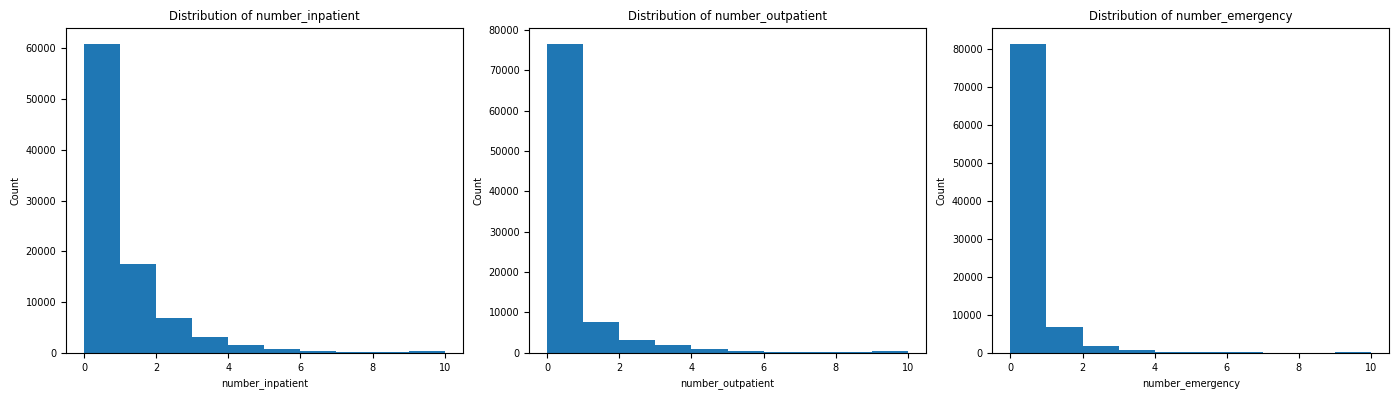

In [65]:
plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=10)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_616\772264036.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[cols], labels=cols)


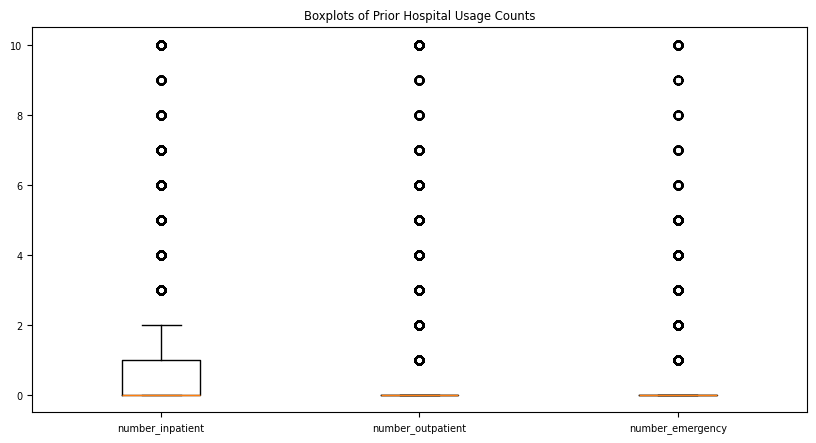

In [66]:
plt.figure(figsize=(10,5))
plt.boxplot(df[cols], labels=cols)
plt.title("Boxplots of Prior Hospital Usage Counts")
plt.show()


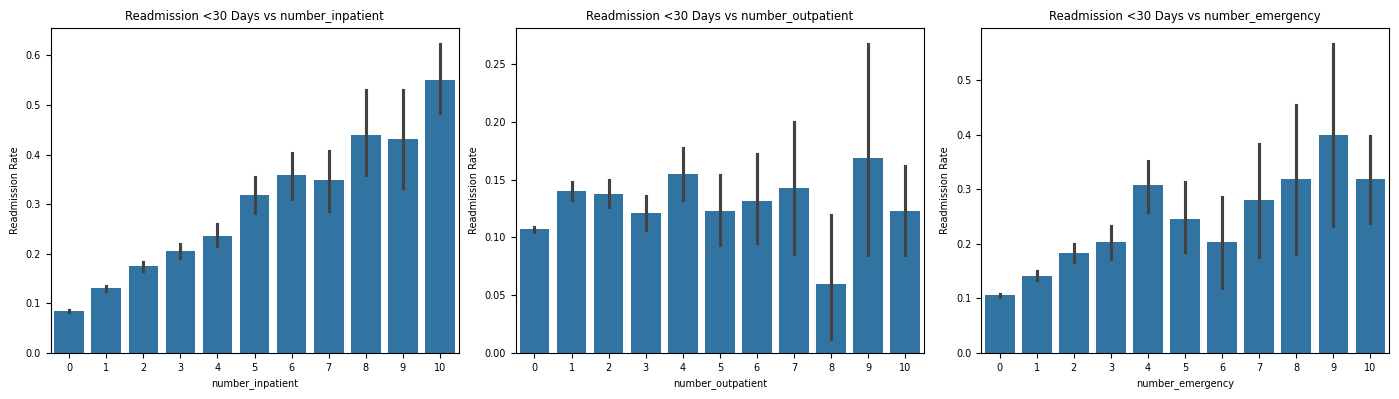

In [67]:
import seaborn as sns

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df[col], y=(df["readmitted"]=="<30").astype(int))
    plt.title(f"Readmission <30 Days vs {col}")
    plt.ylabel("Readmission Rate")

plt.tight_layout()
plt.show()


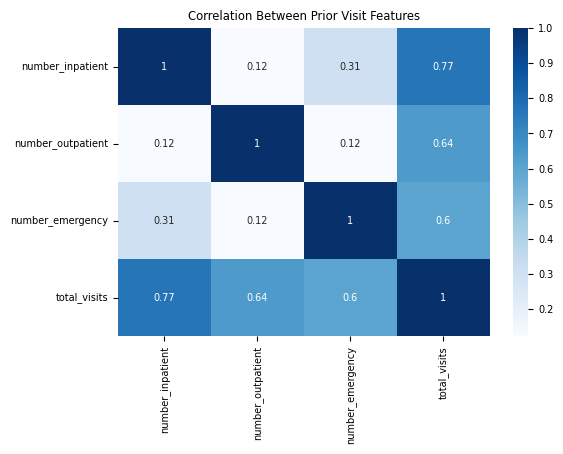

In [68]:
plt.figure(figsize=(6,4))
sns.heatmap(df[cols + ["total_visits"]].corr(), annot=True, cmap="Blues")
plt.title("Correlation Between Prior Visit Features")
plt.show()

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (modify if needed)
df = pd.read_csv(TRAINING_DATA_FILEPATH)

# Columns to clean
encounter_cols = [
    "time_in_hospital",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id"
]

# Convert to numeric
df[encounter_cols] = df[encounter_cols].apply(pd.to_numeric, errors="coerce")

# Replace any NaN with a special category (rare)
df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]] = \
    df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]].fillna(-1)

# Ensure time_in_hospital has no NaN
df["time_in_hospital"] = df["time_in_hospital"].fillna(df["time_in_hospital"].median())

df[encounter_cols].head()


,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id
0,3,1,1,7
1,2,1,1,7
2,2,1,1,7
3,1,1,1,7
4,3,2,1,2


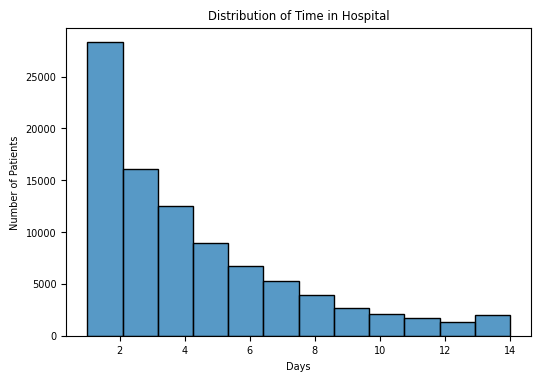

In [70]:
plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=12, kde=False)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Number of Patients")
plt.show()


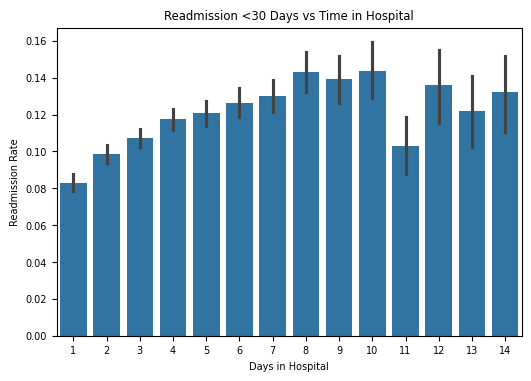

In [71]:
plt.figure(figsize=(6,4))
sns.barplot(x=df["time_in_hospital"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Readmission Rate")
plt.show()


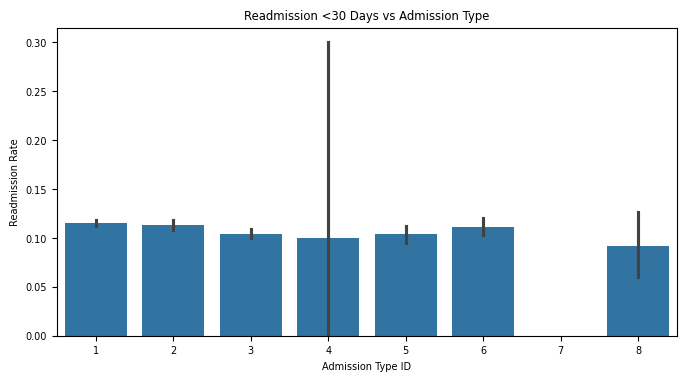

In [72]:
plt.figure(figsize=(8,4))
sns.barplot(x=df["admission_type_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Readmission Rate")
plt.show()


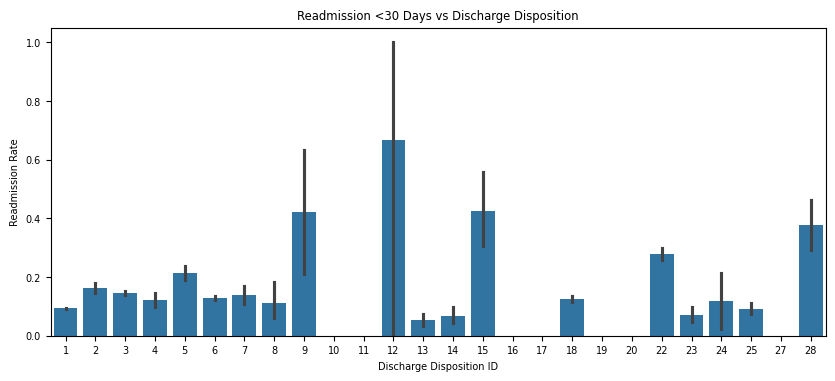

In [73]:
plt.figure(figsize=(10,4))
sns.barplot(x=df["discharge_disposition_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Discharge Disposition")
plt.xlabel("Discharge Disposition ID")
plt.ylabel("Readmission Rate")
plt.show()


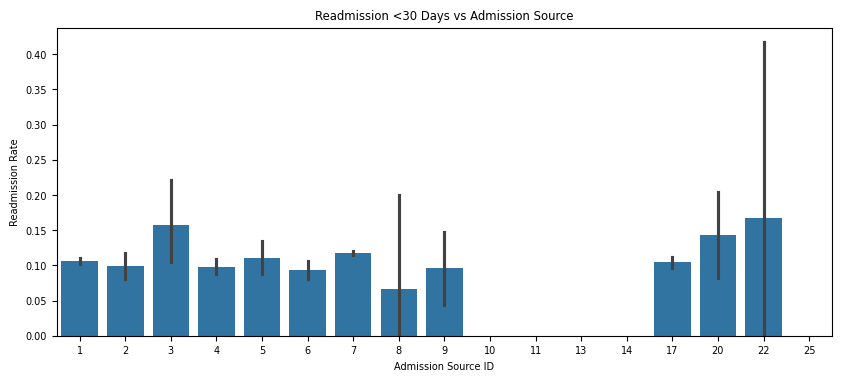

In [74]:
plt.figure(figsize=(10,4))
sns.barplot(x=df["admission_source_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Source")
plt.xlabel("Admission Source ID")
plt.ylabel("Readmission Rate")
plt.show()


# 4. Methodology Overview
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 5. Model Training & Validation
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [75]:
# Preprocessing for PyTorch model (uses selected 6 features)
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Selected features
FEATURES = ['number_inpatient','time_in_hospital','num_medications','number_diagnoses','admission_source_id','discharge_disposition_id']
# Use the training_data DataFrame already loaded earlier in the notebook
df = training_data.copy()
# Map target to integers: '<30'->0, '>30'->1, 'NO'->2
target_map = {'<30':0, '>30':1, 'NO':2}
df['target'] = df['readmitted'].map(target_map)
# Drop rows without a valid target
df = df.dropna(subset=['target'])
# Ensure numeric and fill missing values
df[FEATURES] = df[FEATURES].apply(pd.to_numeric, errors='coerce')
df[FEATURES] = df[FEATURES].fillna(0)
X = df[FEATURES].values
y = df['target'].astype(int).values
# Split and scale
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
print('Training samples:', len(X_train), 'Validation samples:', len(X_val))
# Torch Dataset / DataLoader
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
batch_size = 64
train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

Training samples: 73271 Validation samples: 18318


In [76]:
# Deep feed-forward PyTorch model with many layers and Adam optimizer
import torch.nn as nn
input_dim = len(FEATURES)
num_classes = 3
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(input_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
# Adam optimizer (as requested)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
def accuracy(preds, y):
    return (preds.argmax(dim=1) == y).float().mean().item()
epochs = 20
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
        total_acc += (out.argmax(dim=1) == yb).sum().item()
    train_loss = total_loss / len(train_ds)
    train_acc = total_acc / len(train_ds)
    # validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)
            val_loss += loss.item() * xb.size(0)
            val_acc += (out.argmax(dim=1) == yb).sum().item()
    val_loss = val_loss / len(val_ds)
    val_acc = val_acc / len(val_ds)
    print(f'Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}')
# Save model state and scaler separately for safe loading
torch.save(model.state_dict(), 'readmit_model_state.pth')
import joblib
joblib.dump(scaler, 'scaler.pkl')
print('Model and scaler saved.')


Epoch 1: train_loss=0.9257 train_acc=0.5613 val_loss=0.9084 val_acc=0.5718
Epoch 2: train_loss=0.9134 train_acc=0.5660 val_loss=0.9012 val_acc=0.5730
Epoch 3: train_loss=0.9100 train_acc=0.5693 val_loss=0.8988 val_acc=0.5750
Epoch 4: train_loss=0.9073 train_acc=0.5704 val_loss=0.8994 val_acc=0.5746
Epoch 5: train_loss=0.9041 train_acc=0.5715 val_loss=0.8958 val_acc=0.5734
Epoch 6: train_loss=0.9030 train_acc=0.5716 val_loss=0.8946 val_acc=0.5747
Epoch 7: train_loss=0.9024 train_acc=0.5718 val_loss=0.8952 val_acc=0.5712
Epoch 8: train_loss=0.9011 train_acc=0.5714 val_loss=0.8942 val_acc=0.5744
Epoch 9: train_loss=0.9001 train_acc=0.5725 val_loss=0.8929 val_acc=0.5738
Epoch 10: train_loss=0.8999 train_acc=0.5715 val_loss=0.8932 val_acc=0.5746
Epoch 11: train_loss=0.8999 train_acc=0.5720 val_loss=0.8936 val_acc=0.5757
Epoch 12: train_loss=0.8988 train_acc=0.5724 val_loss=0.8919 val_acc=0.5758
Epoch 13: train_loss=0.8985 train_acc=0.5724 val_loss=0.8919 val_acc=0.5768
Epoch 14: train_loss=

# 6. Results
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 7. Final Predictions on Test Set
Code for the equivalent section in your report, together with in-line documentation of 
that code.

Accuracy: 0.5748255871081851
Balanced accuracy: 0.3949469826562558

Classification report:
               precision    recall  f1-score   support

         <30       1.00      0.00      0.00      1112
         >30       0.48      0.34      0.40      3556
          NO       0.61      0.84      0.70      5509

    accuracy                           0.57     10177
   macro avg       0.70      0.39      0.37     10177
weighted avg       0.61      0.57      0.52     10177



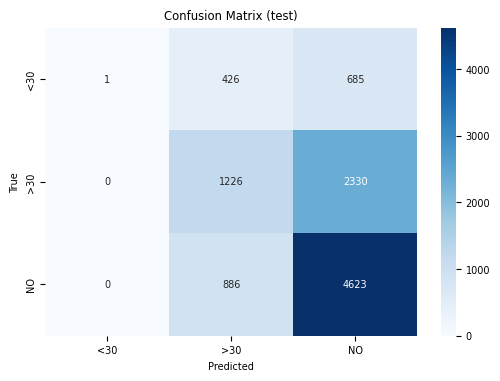

Saved test_predictions.csv


In [77]:
# Evaluate saved model on the test set and print metrics
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load model state dict and scaler saved separately
state_dict = torch.load('readmit_model_state.pth', map_location=device)
scaler = joblib.load('scaler.pkl')
# Recreate model and load weights (Net and input_dim are defined in earlier cell)
model = Net(input_dim).to(device)
model.load_state_dict(state_dict)
model.eval()

# Load and prepare test set
test_df = pd.read_csv(TEST_DATA_FILEPATH)
test_df['target'] = test_df['readmitted'].map({'<30':0, '>30':1, 'NO':2})
test_df = test_df.dropna(subset=['target'])
test_df[FEATURES] = test_df[FEATURES].apply(pd.to_numeric, errors='coerce')
test_df[FEATURES] = test_df[FEATURES].fillna(0)
X_test = scaler.transform(test_df[FEATURES].values)
y_test = test_df['target'].astype(int).values

# DataLoader for test set
batch_size = 256
test_ds = TabularDataset(X_test, y_test)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

print('Accuracy:', accuracy_score(all_true, all_preds))
print('Balanced accuracy:', balanced_accuracy_score(all_true, all_preds))
print('\nClassification report:\n', classification_report(all_true, all_preds, target_names=['<30','>30','NO']))

cm = confusion_matrix(all_true, all_preds, labels=[0,1,2])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['<30','>30','NO'], yticklabels=['<30','>30','NO'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (test)')
plt.show()

# Save predictions alongside test rows
test_df['pred'] = all_preds
test_df.to_csv('test_predictions.csv', index=False)
print('Saved test_predictions.csv')


In [78]:
# Threshold Optimization: Find optimal decision thresholds using validation set
import torch
import numpy as np
from sklearn.metrics import f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get validation set probabilities
model.eval()
val_probs = []
val_preds_true = []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        val_probs.extend(probs)
        val_preds_true.extend(yb.numpy())

val_probs = np.array(val_probs)
val_preds_true = np.array(val_preds_true)

# Grid search over thresholds to maximize F1-score
# For a 3-class problem, we search thresholds for each class
thresholds_range = np.linspace(0.1, 0.9, 20)
best_f1 = 0.0
best_thresholds = [0.33, 0.33, 0.33]

for t0 in thresholds_range:
    for t1 in thresholds_range:
        t2 = 1.0 - t0 - t1
        if t2 <= 0 or t2 >= 1:
            continue
        # Apply thresholds: argmax only if probability > threshold for that class
        val_preds_thresh = []
        for probs in val_probs:
            if np.max(probs) < 0.5:  # If no class exceeds 50%, use argmax
                val_preds_thresh.append(np.argmax(probs))
            else:
                class_idx = np.argmax(probs)
                thresholds = [t0, t1, t2]
                if probs[class_idx] >= thresholds[class_idx]:
                    val_preds_thresh.append(class_idx)
                else:
                    val_preds_thresh.append(np.argmax(probs))
        val_preds_thresh = np.array(val_preds_thresh)
        f1 = f1_score(val_preds_true, val_preds_thresh, average='weighted', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresholds = [t0, t1, t2]

print(f'Best F1-score with thresholds: {best_f1:.4f}')
print(f'Optimal thresholds: class 0 = {best_thresholds[0]:.3f}, class 1 = {best_thresholds[1]:.3f}, class 2 = {best_thresholds[2]:.3f}')


Best F1-score with thresholds: 0.5207
Optimal thresholds: class 0 = 0.100, class 1 = 0.100, class 2 = 0.800


=== THRESHOLD-OPTIMIZED TEST RESULTS ===
Accuracy: 0.5748255871081851
Balanced accuracy: 0.3949469826562558

Classification report:
               precision    recall  f1-score   support

         <30       1.00      0.00      0.00      1112
         >30       0.48      0.34      0.40      3556
          NO       0.61      0.84      0.70      5509

    accuracy                           0.57     10177
   macro avg       0.70      0.39      0.37     10177
weighted avg       0.61      0.57      0.52     10177



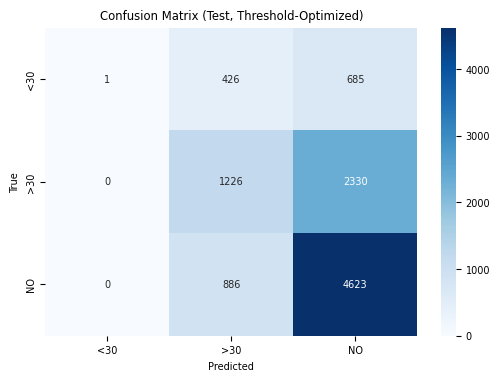


Threshold optimization complete.


In [79]:
# Apply threshold-optimized predictions to test set
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get test set probabilities
test_probs = []
test_preds_true = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        test_probs.extend(probs)
        test_preds_true.extend(yb.numpy())

test_probs = np.array(test_probs)
test_preds_true = np.array(test_preds_true)

# Apply threshold-optimized predictions
test_preds_thresh = []
for probs in test_probs:
    if np.max(probs) < 0.5:
        test_preds_thresh.append(np.argmax(probs))
    else:
        class_idx = np.argmax(probs)
        if probs[class_idx] >= best_thresholds[class_idx]:
            test_preds_thresh.append(class_idx)
        else:
            test_preds_thresh.append(np.argmax(probs))

test_preds_thresh = np.array(test_preds_thresh)

# Evaluate threshold-optimized predictions
print('=== THRESHOLD-OPTIMIZED TEST RESULTS ===')
print('Accuracy:', accuracy_score(test_preds_true, test_preds_thresh))
print('Balanced accuracy:', balanced_accuracy_score(test_preds_true, test_preds_thresh))
print('\nClassification report:\n', classification_report(test_preds_true, test_preds_thresh, target_names=['<30','>30','NO']))

# Confusion matrix for threshold-optimized predictions
cm_thresh = confusion_matrix(test_preds_true, test_preds_thresh, labels=[0,1,2])
plt.figure(figsize=(6,4))
sns.heatmap(cm_thresh, annot=True, fmt='d', xticklabels=['<30','>30','NO'], yticklabels=['<30','>30','NO'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test, Threshold-Optimized)')
plt.show()

print('\nThreshold optimization complete.')
